<a href="https://colab.research.google.com/github/MuhammadBilalH/User_Complaints_Identification/blob/main/Intent_Classification_for_user_complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
!pip install h2o

     |████████████████████████████████| 164.6MB 75kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.3-py2.py3-none-any.whl size=164649662 sha256=51a07bd5902f761e8bedc4391827d93ea6ca6b503c9bbbeb8dd82c4d38fa4bfd
  Stored in directory: /root/.cache/pip/wheels/0a/fd/63/96d322a27867a81a2904172a75aed5241913d603a4b8c4b277
Successfully built h2o


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import h2o
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmfni4xav
  JVM stdout: /tmp/tmpmfni4xav/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmfni4xav/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_unknownUser_gc4fua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df=pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true',compression='zip',sep=',',quotechar='"')

In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704


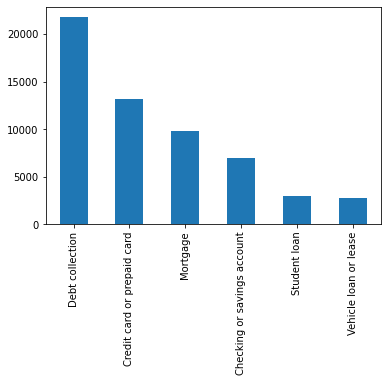

In [ ]:
df['Product'].value_counts().plot(kind='bar')

In [ ]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
TOP FLITE FINANCIAL INC                     1
DIRECT LENDERS LLC                          1
Professional Collectors Corp.               1
National Mediation Services                 1
Credit Collections Services, Inc.           1
Name: Company, Length: 2197, dtype: int64

In [ ]:
compl_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})
compl_df.head()

,complaints,Product,Company
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc."


In [ ]:
compl_df.Product.unique()

array(['Vehicle loan or lease', 'Debt collection',
       'Checking or savings account', 'Mortgage',
       'Credit card or prepaid card', 'Student loan'], dtype=object)

In [ ]:
target={'Vehicle loan or lease':0,'Debt collection':1,'Checking or savings account':2,'Mortgage':3,'Credit card or prepaid card':4,'Student loan':5}

In [ ]:
compl_df['target']=compl_df.Product.map(target)
compl_df.head()

,complaints,Product,Company,target
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,0
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings,1
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,0
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,2
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc.",1


In [ ]:
X_train ,X_test = train_test_split(compl_df,test_size=0.8)

In [ ]:
stemmer=nltk.stem.SnowballStemmer('english')


In [ ]:
nltk.download('stopwords')
stop_words=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text) if (len(word)>3 and len(word.strip('Xx/'))>2 and len(re.sub('\d+', '', word.strip('Nn/')))>3)]
  tokens = map(str.lower,tokens)
  stems= [stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems

In [ ]:
vectorizer_TF=TfidfVectorizer(tokenizer=tokenize,stop_words=None,max_df=0.8,max_features=1000,lowercase=False,ngram_range=(1,2))
train_vector=vectorizer_TF.fit_transform(X_train.complaints)

In [ ]:
train_vector.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.04718218, 0.        , ..., 0.        , 0.        ,
        0.03768687],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06388211]])

In [ ]:
vectorizer_TF.get_feature_names()

['abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amex',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'assess',
 'asset',
 'assign',
 'assist',
 'associ',
 'assum',
 'assur

In [ ]:
test_vector = vectorizer_TF.transform(X_test.complaints)

In [ ]:
X_train.shape

(11490, 4)

In [ ]:
train_df=pd.DataFrame(train_vector.toarray(),columns=vectorizer_TF.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)],axis=1)
train_df.head()

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account bank,account call,account close,account credit,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,agenc,agent,...,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would receiv,would take,write,written,wrong,wrote,xx/xx/2018,xx/xx/2019,xx/xx/2019 receiv,xx/xx/2020,year,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.104296,0.177946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140745,0.0,0.00000,0.0,0.0,0.0,0.094757,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.21411,0.0,0.0,0.000000,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.058997,0.075494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.048851,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125738,0.00000,0.0,0.0,0.234304,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.024448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050987,0.000000,0.0,0.0,0.076126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.055726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.07138,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.030944,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.182103,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,1


In [ ]:
test_df=pd.DataFrame(test_vector.toarray(),columns=vectorizer_TF.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)],axis=1)
test_df.head()

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account bank,account call,account close,account credit,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,agenc,agent,...,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would receiv,would take,write,written,wrong,wrote,xx/xx/2018,xx/xx/2019,xx/xx/2019 receiv,xx/xx/2020,year,target
0,0.29208,0.102349,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.193814,0.0,0.0,0.00000,0.0,0.119007,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.081752,1
1,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0775,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126555,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0
2,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0000,0.087203,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.12618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.055187,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2
3,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0000,0.026828,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.156237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.122301,0.0,0.000000,0.0,0.0,0.0,0.102152,0.150449,0.052623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033956,0.0,0.0,0.00000,0.0,0.187649,0.0,0.0,0.0,0.0,0.0,0.0,0.117035,0.000000,2
4,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0000,0.095623,0.0,0.0,0.0,0.0,0.129328,0.0,0.042986,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076491,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.028137,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030507,0.0,0.0,0.100859,0.0,0.0,0.04867,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4


In [ ]:
h2o_train_df=h2o.H2OFrame(train_df)
h2o_test_df=h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
h2o_train_df['target']=h2o_train_df['target'].asfactor()
h2o_test_df['target']=h2o_test_df['target'].asfactor()

In [ ]:
aml=H2OAutoML(max_models=10, seed=10, exclude_algos=["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)
x=vectorizer_TF.get_feature_names()
y='target'

In [ ]:
aml.train(x=x,y=y,training_frame=h2o_train_df,validation_frame=h2o_test_df)

AutoML progress: |
15:48:18.495: Project: AutoML_20210110_154818490
15:48:18.496: Cross-validation disabled by user: no fold column nor nfolds > 1.
15:48:18.501: Setting stopping tolerance adaptively based on the training frame: 0.00932910509720565
15:48:18.501: Build control seed: 10
15:48:18.501: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
15:48:20.433: training frame: Frame key: automl_training_py_1_sid_944f    cols: 1001    rows: 10335  chunks: 14    size: 8484905  checksum: 7341966894150270804
15:48:20.438: validation frame: Frame key: py_2_sid_944f    cols: 1001    rows: 45963  chunks: 53    size: 37693629  checksum: 8980110672169702544
15:48:20.645: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_944f    cols: 1001    rows: 1155  chunks: 14    size: 1916307  checksum: -2412822936694656964
15:48:20.645: blending frame: NULL
15:48:20.645: response 